In [ ]:
!pip install fitdecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.6 MB/s eta 0:00:00


In [ ]:
f1 = open('/content/2_5303101742206956507.fit', 'r')

In [ ]:
record = ['latitude', 'longitude', 'altitude', 'timestamp', 'heart_rate', 'cadence', 'speed', 'distance']

In [ ]:
import fitdecode
import pandas as pd
import os
from datetime import datetime, timedelta
from typing import Dict, Union, Optional, Tuple


In [ ]:
def get_fit_point_data(frame: fitdecode.records.FitDataMessage) -> Optional[Dict[str, Union[float, int, str, datetime]]]:

  data: Dict[str, Union[float, int, str, datetime]] = {}

  if not (frame.has_field('position_lat') and frame.has_field('position_long')):
    return None
  else:
    #data['latitude']=frame.get_value('position_lat') / ((2**32) / 360)
    #data['longitude']=frame.get_value('position_long') / ((2**32) / 360)
    lat_=frame.get_value('position_lat')
    long_=frame.get_value('position_long')
    data['latitude']=lat_
    data['longitude'] = long_
    if (lat_ is not None) and (long_ is not None):
      data['latitude'] = float(lat_) / ((2**32) / 360)
      data['longitude'] = float(long_) / ((2**32) / 360)

  for field in record[2: ]:
    if frame.has_field(field):
      data[field] = frame.get_value(field)

  return data


In [ ]:
def get_fit_other_data(col, frame: fitdecode.records.FitDataMessage) -> Optional[Dict[str, Union[float, int, str, datetime]]]:

  data: Dict[str, Union[float, int, str, datetime]] = {}

  for field in col:
    if frame.has_field(field):
      data[field] = frame.get_value(field)

  return data

In [ ]:
record_data = []
with fitdecode.FitReader('/content/2_5303101742206956507.fit') as fit_file:
  for frame in fit_file:
    if isinstance(frame, fitdecode.records.FitDataMessage):
      if frame.name == 'record':
        single_point_data = get_fit_point_data(frame)
        if single_point_data is not None:
          record_data.append(single_point_data)

#получилось удалить строки со значениями NaN, чтобы трек на карте отобразился нормально
record_df = pd.DataFrame(record_data, columns=record)
record_df = record_df.dropna(0)
record_df

/usr/local/lib/python3.10/dist-packages/fitdecode/reader.py:909: UserWarning: 'field "native_field_num" (idx #0) not found in message "field_description"' (local_mesg_num: 0; chunk_offset: 194); adding dummy dev data...
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fitdecode/reader.py:909: UserWarning: 'field "native_field_num" (idx #0) not found in message "field_description"' (local_mesg_num: 0; chunk_offset: 236); adding dummy dev data...
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fitdecode/reader.py:909: UserWarning: 'field "native_field_num" (idx #0) not found in message "field_description"' (local_mesg_num: 0; chunk_offset: 287); adding dummy dev data...
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fitdecode/reader.py:909: UserWarning: 'field "native_field_num" (idx #0) not found in message "field_description"' (local_mesg_num: 0; chunk_offset: 328); adding dummy dev data...
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packa

,latitude,longitude,altitude,timestamp,heart_rate,cadence,speed,distance
16,43.248723,42.526270,2079.0,2023-02-21 09:47:35+00:00,100.0,55.0,1.650,14.0
17,43.248726,42.526266,2079.0,2023-02-21 09:47:36+00:00,100.0,48.0,1.650,14.0
18,43.248729,42.526262,2079.0,2023-02-21 09:47:37+00:00,100.0,48.0,1.447,16.0
19,43.248730,42.526253,2079.0,2023-02-21 09:47:38+00:00,100.0,48.0,1.247,18.0
20,43.248732,42.526243,2079.0,2023-02-21 09:47:39+00:00,100.0,49.0,1.206,19.0
...,...,...,...,...,...,...,...,...
3690,43.245370,42.522847,2088.0,2023-02-21 11:18:17+00:00,100.0,44.0,0.844,3052.0
3691,43.245364,42.522853,2088.0,2023-02-21 11:18:18+00:00,100.0,45.0,0.864,3053.0
3692,43.245357,42.522859,2088.0,2023-02-21 11:18:19+00:00,100.0,47.0,0.886,3054.0
3693,43.245343,42.522867,2088.0,2023-02-21 11:18:20+00:00,100.0,47.0,0.900,3054.0


In [ ]:
#пакеты для обработки геометрии
from pyproj import CRS
import geopandas as gpd
from shapely.geometry import LineString

In [ ]:
#границы экстента геометрии и центр
line = gpd.GeoDataFrame(crs = CRS('EPSG:4326'), geometry = [LineString(zip(record_df.longitude, record_df.latitude))])
line_centroid = line.centroid
line_bounds = line.bounds

<ipython-input-57-46c92cbdd04c>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  line_centroid = line.centroid


In [ ]:
#визуализация
import folium
m = folium.Map([line_centroid.y, line_centroid.x], tiles = 'cartodb positron')
folium.GeoJson(line).add_to(m)
folium.FitBounds([[line_bounds.miny[0], line_bounds.minx[0]], [line_bounds.maxy[0], line_bounds.maxx[0]]]).add_to(m)
m

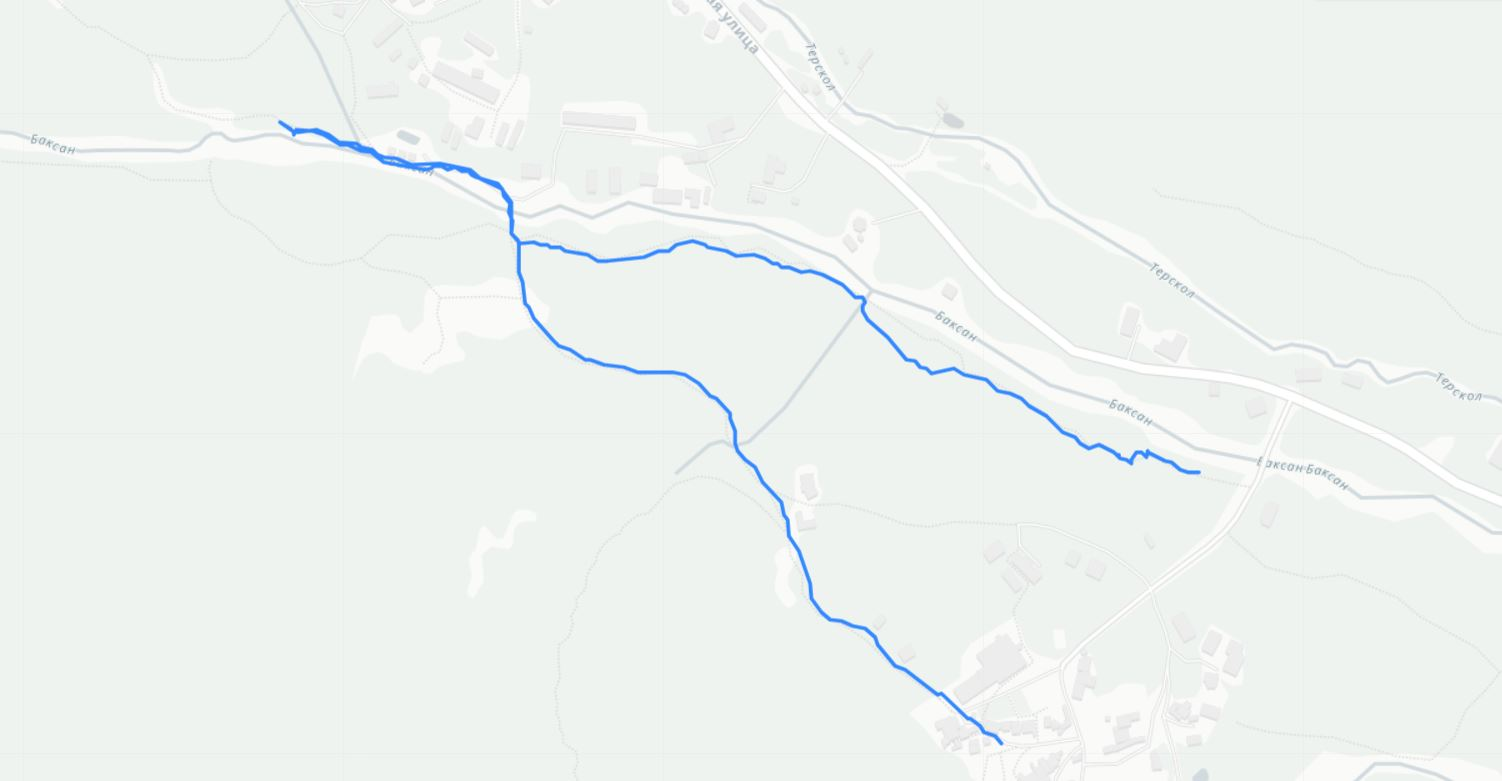

In [ ]:
#график
import altair as alt
alt.Chart(record_df).mark_point().encode(
    y = 'cadence',
    x = 'distance',
    color = 'heart_rate',
).interactive()

alt.Chart(...)

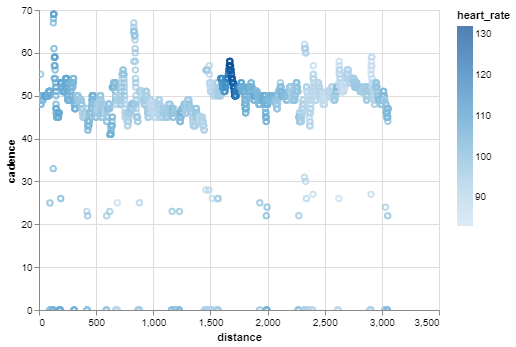

In [ ]:
#график
import altair as alt
alt.Chart(record_df).mark_point(
    filled = True
).encode(
    y = 'cadence',
    x = 'distance',
    color = 'heart_rate:N',
    tooltip = 'speed'  # можно добавить всплывающие подсказки со скоростью
).configure_axis(
    labelFontSize=14,  # Изменяем размер шрифта на осях
    titleFontSize=16,  # Изменяем размер шрифта заголовка
).interactive()

alt.Chart(...)

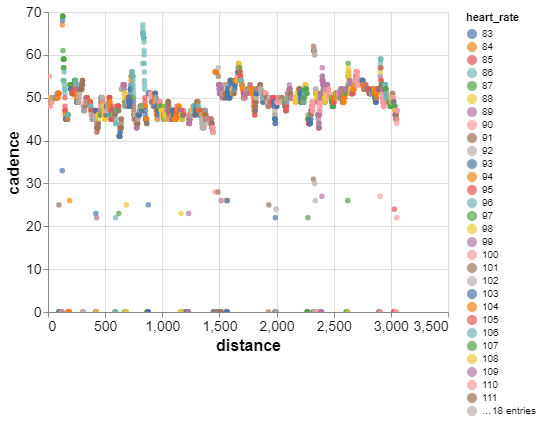